In [2]:
# from datasets import load_dataset
# dataset_paths = ["weathon/aas_benchmark-nano-banana","weathon/aas_benchmark-stable_diffusion_xl","weathon/aas_benchmark-flux_krea","weathon/aas_benchmark-flux_dev","weathon/aas_benchmark-grpo_flux","weathon/aas_benchmark-playground","weathon/aas_benchmark-sd3_medium_grpo","weathon/aas_benchmark-sd3_medium_grpo_geneval","weathon/aas_benchmark-stable_diffusion_3.5_medium","weathon/aas_benchmark-sd3_medium_grpo","weathon/aas_benchmark-dance_flux"]

In [3]:
# datasets = [load_dataset(path, split="train") for path in dataset_paths]

In [4]:
# from datasets import concatenate_datasets
# dataset = concatenate_datasets(datasets)

In [5]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark", split="train")

In [6]:
from PIL import Image
from pydantic import BaseModel
from io import BytesIO
import base64
from typing import Literal
from openai import OpenAI 


class JudgeResponse(BaseModel):
    reasoning: str
    main_concepts: int
    special_effects: int


def encode_image(image: Image.Image) -> str:
    buffer = BytesIO()
    image.save(buffer, format="PNG")
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


def ensure_percentage(value: int) -> None:
    if not (0 <= value <= 100):
        raise ValueError(f"LLM returned value outside 0-100 range: {value}")


In [7]:
import os
import dotenv
dotenv.load_dotenv()
deepinfra_api_key = os.getenv("DEEPNFRA_API_KEY")
openrouter_api_key = os.getenv("OPENROUTER_API_KEY")
openai = OpenAI(
    api_key=openrouter_api_key,
    base_url="https://openrouter.ai/api/v1",
)



In [9]:
def judge(image: Image.Image, original_prompt: str, distorted_prompt: str) -> JudgeResponse:
    encoded = encode_image(image)
    messages = [
        {"role": "system", "content": "You are a strict image judge. Reply with a JSON object that matches the provided schema."},
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": (
                        f"Original prompt:\n{original_prompt}\n\nDistorted prompt:\n{distorted_prompt}\n\nEvaluate the image using following rules with integer scores between 0 and 100 (inclusive):\n\n1. Main concept (0-100): Rate how clearly the main subjects or scenes from the original prompt appear in the distorted image. Do not reduce this score if visual effects or distortions make them harder to see but they are still recognizable.\n\n2. Special effects (0-100): Rate how accurately the effects described in the distorted prompt are represented. This score should be continuous, not binary. 100 means all effects are clearly present, 0 means none are visible.\n\nProcedure (do this in the reasoning part):\n- List the main visual effects mentioned in the distorted prompt.\n- Check each of these effects how much they are visible in the image.\n- Compute a smooth score based on the proportion of effects that appear.\n\nKeep the reasoning concise and limited to listing and checking effects."
                    ),
                },
                {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{encoded}"}},
            ],
        },
    ]
    for attempt in range(5): 
        try:
            response = openai.chat.completions.parse(
                model="google/gemini-2.5-flash",
                messages=messages,
                response_format=JudgeResponse,
                temperature=0.1,
            )
            parsed = response.choices[0].message.parsed
            ensure_percentage(parsed.main_concepts)
            ensure_percentage(parsed.special_effects)
            return parsed
        except Exception as exc:
            if attempt == 4:
                raise
            print(f"retrying llm judge due to error: {exc}")
    


In [10]:
dataset

Dataset({
    features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model'],
    num_rows: 3300
})

In [11]:
def process_example(example):
    original_judge = judge(example["image_original"], example["prompt_original"], example["prompt_distorted"])
    distorted_judge = judge(example["image_distorted"], example["prompt_original"], example["prompt_distorted"])

    example["llm_judge"] = {
            "llm_original_reasoning": original_judge.reasoning,
            "llm_original_main_concepts": original_judge.main_concepts,
            "llm_original_special_effects": original_judge.special_effects,
            "llm_distorted_reasoning": distorted_judge.reasoning,
            "llm_distorted_main_concepts": distorted_judge.main_concepts,
            "llm_distorted_special_effects": distorted_judge.special_effects,
        }
    return example

In [12]:
dataset = dataset.map(process_example, batched=False, num_proc=100) 

/home/wg25r/.local/lib/python3.10/site-packages/dill/_dill.py:414: PicklingWarning: Cannot locate reference to <class '__main__.JudgeResponse'>.
  StockPickler.save(self, obj, save_persistent_id)
/home/wg25r/.local/lib/python3.10/site-packages/dill/_dill.py:414: PicklingWarning: Cannot pickle <class '__main__.JudgeResponse'>: __main__.JudgeResponse has recursive self-references that trigger a RecursionError.
  StockPickler.save(self, obj, save_persistent_id)
Parameter 'function'=<function process_example at 0x760f9738acb0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only shown once. Subsequent hashing failures won't be shown.


Map (num_proc=100):   0%|          | 0/3300 [00:00<?, ? examples/s]

In [13]:
dataset

Dataset({
    features: ['image_original', 'image_distorted', 'index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'hpsv2', 'llm_judge', 'model'],
    num_rows: 3300
})

In [14]:
dataset.push_to_hub("weathon/aas_benchmark", private=True)

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        :   6%|6         | 50.3MB /  778MB            

CommitInfo(commit_url='https://huggingface.co/datasets/weathon/aas_benchmark/commit/8442de9641b153eb8cb4cf4cd2a93ff2b7920262', commit_message='Upload dataset', commit_description='', oid='8442de9641b153eb8cb4cf4cd2a93ff2b7920262', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/weathon/aas_benchmark', endpoint='https://huggingface.co', repo_type='dataset', repo_id='weathon/aas_benchmark'), pr_revision=None, pr_num=None)

In [1]:
from datasets import load_dataset
dataset = load_dataset("weathon/aas_benchmark", split="train")

In [2]:
from hpsv3 import HPSv3RewardInferencer

inferencer = HPSv3RewardInferencer(device='cuda:2')

Flash Attention is not installed. Falling to SDPA.


`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some weights of Qwen2VLRewardModelBT were not initialized from the model checkpoint at Qwen/Qwen2-VL-7B-Instruct and are newly initialized: ['rm_head.0.bias', 'rm_head.0.weight', 'rm_head.3.bias', 'rm_head.3.weight', 'rm_head.5.bias', 'rm_head.5.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import torch
def hpsv3_reward(sample):
    images = []
    prompts = [] 
    images_part = [sample["image_original"], sample["image_original"], sample["image_distorted"],  sample["image_distorted"]]
    prompts_part = [
        sample["prompt_original"],
        sample["prompt_distorted"],
        sample["prompt_original"],
        sample["prompt_distorted"]
    ] 
    images.extend(images_part)
    prompts.extend(prompts_part)

    with torch.no_grad():
        rewards = inferencer.reward(prompts=prompts, image_paths=images)
    results = []
    for i in range(0, len(rewards), 4):
        results.append({
            "hpsv3_oiop": rewards[i], # original image, original prompt
            "hpsv3_oidp": rewards[i+1], # original image, distorted prompt
            "hpsv3_diop": rewards[i+2], # distorted image, original prompt
            "hpsv3_didp": rewards[i+3], # distorted image, distorted prompt 
        })
    sample["hpsv3_reward"] = results
    return sample
  


In [ ]:
hpsv3_reward(dataset[0])   

{'image_original': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 'image_distorted': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024>,
 'index': 0,
 'prompt_original': 'A standing toilet in a bathroom stall next to a trash can.',
 'prompt_distorted': 'A standing toilet in a bathroom stall beside a trash can, rendered with no light or shadow, appearing random and unfinished, lacking clear intent or design, with flat, indistinct surfaces and no depth or texture.',
 'selected_dims': '["richness", "lighting distinction"]',
 'hpsv2': {'distorted': 0.0,
  'distorted_original_prompt': 0.0,
  'original': 0.0,
  'original_distorted_prompt': 0.0},
 'llm_judge': {'llm_distorted_main_concepts': 100,
  'llm_distorted_reasoning': 'The original prompt describes a standing toilet in a bathroom stall next to a trash can. The distorted prompt adds stylistic effects: no light or shadow, random and unfinished appearance, lack of clear intent or design, flat and indistinct

In [ ]:
dataset = dataset.map(hpsv3_reward)

Map:   0%|          | 0/3300 [00:00<?, ? examples/s]

In [ ]:
import os
import torch
import ImageReward as RM
model = RM.load("ImageReward-v1.0")
prompt = "a painting of an ocean with clouds and birds, day time, low depth field effect"
img_list = ["gpt.png"]
# model = RM.load("ImageReward-v1.0")


load checkpoint from /home/wg25r/.cache/ImageReward/ImageReward.pt


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

checkpoint loaded


In [8]:
import torch
from PIL import Image
with torch.no_grad():
    reward = model.score(prompt, Image.open(img_list[0]))
reward

-2.2784693241119385

In [15]:
import json, pickle

with open("hpsv2_rewards.json", "r") as f:
    hpsv2_rewards = json.load(f)

with open("hpsv3_rewards.pkl", "rb") as f:
    hpsv3_rewards = pickle.load(f)

with open("image_reward.json", "r") as f:
    image_rewards = json.load(f)


In [21]:
hpsv3_rewards_list = []
for i in hpsv3_rewards:
    hpsv3_rewards_list.append({k:v.detach().cpu().numpy().tolist() for k,v in i.items()})
    

In [23]:
assert len(hpsv3_rewards_list) == len(hpsv2_rewards) == len(image_rewards) == len(dataset)

In [25]:
dataset = dataset.add_column("hpsv2_reward", hpsv2_rewards)
dataset = dataset.add_column("hpsv3_reward", hpsv3_rewards_list)
dataset = dataset.add_column("image_reward", image_rewards)

In [ ]:
dataset.push_to_hub("weathon/aas_benchmark", private=True)

In [28]:
llm_distorted_effects = [i["llm_judge"]["llm_distorted_special_effects"] for i in dataset]

In [32]:
hpsv3_rewards_list[0]

{'hpsv3_oiop': [10.158187866210938, -5.01566219329834],
 'hpsv3_oidp': [11.20141315460205, -5.0528950691223145],
 'hpsv3_diop': [2.6279497146606445, -4.130467891693115],
 'hpsv3_didp': [8.689342498779297, -4.920155048370361]}

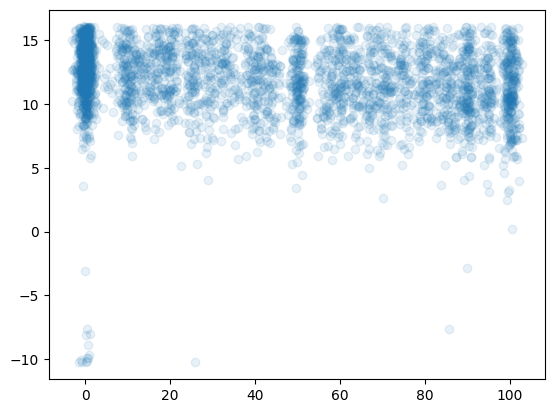

In [43]:
import pylab
import numpy as np
noise = np.random.normal(0, 0.5, size=len(llm_distorted_effects))
pylab.scatter(llm_distorted_effects + noise * 2, [i["hpsv3_didp"][0] for i in hpsv3_rewards_list], alpha=0.1)

In [78]:
from transformers import PreTrainedModel
from transformers import BlipForImageTextRetrieval, BlipProcessor, PretrainedConfig
import torch
class Rater(PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.backbone = backbone    

    def forward(self, pixel_values, input_ids, attention_mask, n_images, labels=None):
        outputs = self.backbone(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
        if labels is not None:
            raise RuntimeError("let it crash: labels not supported in this benchmark")
        return outputs

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
backbone = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco", torch_dtype=torch.float16).to("cuda:2")
rater_config = PretrainedConfig.from_pretrained("weathon/BLIP-Reward")
rater = Rater(rater_config).to("cuda:2")

In [ ]:
with open("prompts.json", "r") as file:
    prompt_dict = json.load(file)


In [80]:
prompt_dict.keys() 

dict_keys(['background', 'clarity', 'color aesthetic', 'color brightness', 'detail realism', 'detail refinement', 'emotion', 'lighting distinction', 'main object', 'object pairing', 'richness', 'symmetry'])

In [185]:
# regression
from scipy.stats import linregress
linregress(llm_distorted_effects, [i["hpsv3_didp"][0] for i in hpsv3_rewards_list]) 

KeyError: 'hpsv2_didp'

In [187]:
# regression
from scipy.stats import linregress
linregress(llm_distorted_effects, [i["hpsv2_didp"] for i in hpsv2_rewards])

LinregressResult(slope=np.float64(-0.00033945158896454044), intercept=np.float64(0.3136189432221136), rvalue=np.float64(-0.27243758632529047), pvalue=np.float64(2.9888886220189485e-57), stderr=np.float64(2.087559527641648e-05), intercept_stderr=np.float64(0.001192683448729193))

In [190]:
# regression
from scipy.stats import linregress
linregress(llm_distorted_effects, [i["image_reward_didp"] for i in image_rewards])

LinregressResult(slope=np.float64(-0.0005730702506451377), intercept=np.float64(1.0821570564929535), rvalue=np.float64(-0.0291826597432472), pvalue=np.float64(0.09371116243551653), stderr=np.float64(0.00034180047295270555), intercept_stderr=np.float64(0.019528054719428402))

In [ ]:
hpsv3 = np.array([i["hpsv3_didp"][0] for i in hpsv3_rewards_list])  

In [44]:
llm_distorted_effects = np.array(llm_distorted_effects)

(array([  8.,   3.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   1.,
          0.,   4.,  16.,  56.,  99., 184., 217., 213., 153.]),
 array([-10.2684164 ,  -8.94998059,  -7.63154478,  -6.31310897,
         -4.99467316,  -3.67623734,  -2.35780153,  -1.03936572,
          0.27907009,   1.5975059 ,   2.91594172,   4.23437753,
          5.55281334,   6.87124915,   8.18968496,   9.50812078,
         10.82655659,  12.1449924 ,  13.46342821,  14.78186402,
         16.10029984]),
 <BarContainer object of 20 artists>)

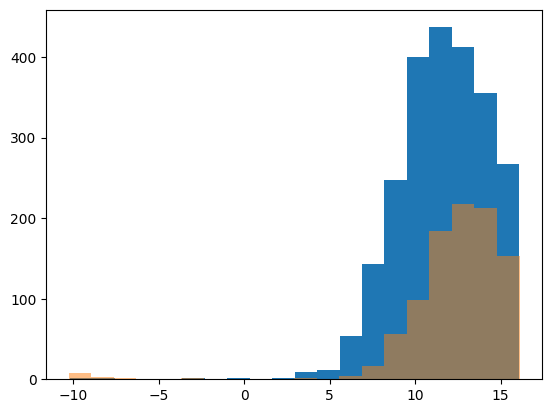

In [58]:
success_index = np.where(llm_distorted_effects > 10)[0]
failed_index = np.where(llm_distorted_effects <= 10)[0]
pylab.hist(hpsv3[success_index], bins=20)
pylab.hist(hpsv3[failed_index], bins=20, alpha=0.5)

In [61]:
delta_hpsv3 = np.array([i["hpsv3_didp"][0] - i["hpsv3_oidp"][0] for i in hpsv3_rewards_list])

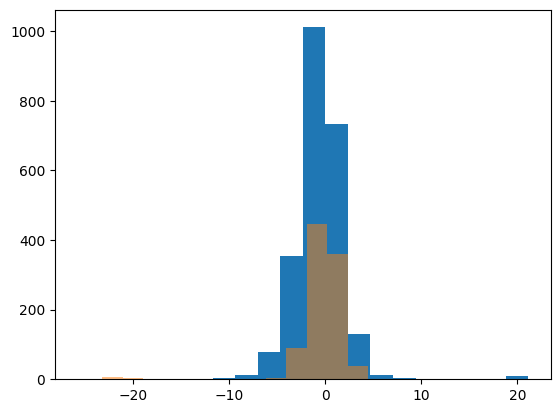

In [62]:
pylab.hist(delta_hpsv3[success_index], bins=20)
pylab.hist(delta_hpsv3[failed_index], bins=20, alpha=0.5) 
pylab.show()

In [65]:
np.median(hpsv3[success_index]), np.median(hpsv3[failed_index]) 

(np.float64(11.676383972167969), np.float64(12.692777633666992))

In [64]:
# U test 
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(hpsv3[success_index], hpsv3[failed_index], alternative='less')
stat, p

(np.float64(876897.0), np.float64(5.153950516151075e-23))

In [159]:
original_images = dataset["image_original"]
distorted_images = dataset["image_distorted"]
dataset = dataset.remove_columns(["image_original", "image_distorted"])

In [ ]:
dim_scores = {}
for sample in dataset:
    selected_dims = json.loads(sample["selected_dims"]) + ["general"]
    for dim in selected_dims:
        old_list = dim_scores.get(dim, [])
        old_list.append([sample["hpsv2_reward"]["hpsv2_didp"], sample["llm_judge"]["llm_distorted_special_effects"]])
        dim_scores[dim] = old_list

In [250]:
dim_scores.keys()

dict_keys(['richness', 'lighting distinction', 'general', 'color aesthetic', 'color brightness', 'main object', 'detail realism', 'object pairing', 'emotion', 'clarity', 'background', 'detail refinement'])

In [253]:
from scipy.stats import spearmanr
print(f"{'Dimension':<30}{'Corr coef':<15}{'p-value':<15}")
print("-" * 70)
for dim in dim_scores.keys():
    if dim == "general":
        continue
    data = np.array(dim_scores[dim])
    res = spearmanr(data[:, 1], data[:, 0])
    print(f"{dim:<30}{res.statistic:<15.4f}{res.pvalue:<15.4e}")

dim = "general"
data = np.array(dim_scores[dim])
res = linregress(data[:, 1], data[:, 0])
print("-" * 70)  
print(f"{dim:<30}{res.rvalue:<15.4f}{res.pvalue:<15.4e}")

Dimension                     Corr coef      p-value        
----------------------------------------------------------------------
richness                      -0.2531        3.9458e-15     
lighting distinction          -0.2488        2.4083e-14     
color aesthetic               -0.3275        1.5695e-21     
color brightness              -0.3009        5.9579e-19     
main object                   -0.2961        8.0722e-21     
detail realism                -0.2501        2.5118e-14     
object pairing                -0.2779        1.2546e-18     
emotion                       -0.2316        2.6077e-12     
clarity                       -0.3815        3.4285e-26     
background                    -0.2628        3.8499e-18     
detail refinement             -0.3029        4.8949e-18     
----------------------------------------------------------------------
general                       -0.2754        1.6201e-58     


["lighting distinction", "richness", "color aesthetic", "detail realism"]
tensor([0.0211, 0.1127], device='cuda:2', dtype=torch.float16)


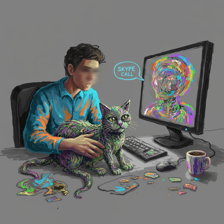

In [234]:
idx = 128
print(dataset[idx]["selected_dims"])
prompt = prompt_dict[json.loads(dataset[idx]["selected_dims"])[1]] 
inputs = processor(images=[original_images[idx], distorted_images[idx]], text=[prompt, prompt], return_tensors="pt", padding=True).to("cuda:2")
with torch.no_grad(): 
    outputs = rater(**inputs, n_images=[2]) 
scores = torch.softmax(outputs["itm_score"], dim=-1)[:, 1]
print(scores)
distorted_images[idx].resize((224, 224))

In [ ]:
dim_scores = {}
for sample in dataset:
    selected_dims = json.loads(sample["selected_dims"]) + ["general"]
    for dim in selected_dims:
        old_list = dim_scores.get(dim, [])
        old_list.append([sample["hpsv3_reward"]["hpsv3_didp"][0], sample["llm_judge"]["llm_distorted_special_effects"]])
        dim_scores[dim] = old_list

In [242]:
from scipy.stats import spearmanr
print(f"{'Dimension':<30}{'Corr coef':<15}{'p-value':<15}")
print("-" * 70)
for dim in dim_scores.keys():
    if dim == "general":
        continue
    data = np.array(dim_scores[dim])
    res = spearmanr(data[:, 1], data[:, 0])
    print(f"{dim:<30}{res.statistic:<15.4f}{res.pvalue:<15.4e}")

dim = "general"
data = np.array(dim_scores[dim])
res = linregress(data[:, 1], data[:, 0])
print("-" * 70)  
print(f"{dim:<30}{res.rvalue:<15.4f}{res.pvalue:<15.4e}")

Dimension                     Corr coef      p-value        
----------------------------------------------------------------------
richness                      -0.1518        3.1034e-06     
lighting distinction          -0.3326        5.0183e-25     
color aesthetic               -0.0476        1.7786e-01     
color brightness              -0.1930        1.8420e-08     
main object                   -0.2096        5.8135e-11     
detail realism                -0.2342        1.0546e-12     
object pairing                -0.2539        1.0603e-15     
emotion                       -0.2202        2.9968e-11     
clarity                       -0.4217        3.4568e-32     
background                    -0.2432        1.1071e-15     
detail refinement             -0.2128        1.9058e-09     
----------------------------------------------------------------------
general                       -0.1714        3.6105e-23     


In [246]:
dim_scores = {}
for sample in dataset:
    selected_dims = json.loads(sample["selected_dims"]) + ["general"]
    for dim in selected_dims:
        old_list = dim_scores.get(dim, [])
        old_list.append([sample["image_reward"]["image_reward_didp"], sample["llm_judge"]["llm_distorted_special_effects"]])
        dim_scores[dim] = old_list

In [247]:
from scipy.stats import spearmanr
print(f"{'Dimension':<30}{'Corr coef':<15}{'p-value':<15}")
print("-" * 70)
for dim in dim_scores.keys():
    if dim == "general":
        continue
    data = np.array(dim_scores[dim])
    res = spearmanr(data[:, 1], data[:, 0])
    print(f"{dim:<30}{res.statistic:<15.4f}{res.pvalue:<15.4e}")

dim = "general"
data = np.array(dim_scores[dim])
res = linregress(data[:, 1], data[:, 0])
print("-" * 70)  
print(f"{dim:<30}{res.rvalue:<15.4f}{res.pvalue:<15.4e}")

Dimension                     Corr coef      p-value        
----------------------------------------------------------------------
richness                      -0.0768        1.8789e-02     
lighting distinction          -0.1221        2.1638e-04     
color aesthetic               0.0107         7.6257e-01     
color brightness              -0.0166        6.3211e-01     
main object                   0.0285         3.7798e-01     
detail realism                -0.0524        1.1582e-01     
object pairing                -0.0219        4.9689e-01     
emotion                       0.0192         5.6628e-01     
clarity                       -0.1222        1.0625e-03     
background                    0.0214         4.8711e-01     
detail refinement             -0.0545        1.2824e-01     
----------------------------------------------------------------------
general                       -0.0292        9.3711e-02     


In [255]:
import pandas as pd
df = pd.DataFrame(dataset)

In [ ]:
df["hpsv2"][0]

{'distorted': 0.0,
 'distorted_original_prompt': 0.0,
 'original': 0.0,
 'original_distorted_prompt': 0.0}

In [272]:
dataset = dataset.remove_columns(["hpsv2"])

In [273]:
df["hpsv2_reward"]

0       {'hpsv2_didp': 0.2291259765625, 'hpsv2_diop': ...
1       {'hpsv2_didp': 0.336669921875, 'hpsv2_diop': 0...
2       {'hpsv2_didp': 0.2166748046875, 'hpsv2_diop': ...
3       {'hpsv2_didp': 0.2476806640625, 'hpsv2_diop': ...
4       {'hpsv2_didp': 0.254638671875, 'hpsv2_diop': 0...
                              ...                        
3295    {'hpsv2_didp': 0.33544921875, 'hpsv2_diop': 0....
3296    {'hpsv2_didp': 0.327880859375, 'hpsv2_diop': 0...
3297    {'hpsv2_didp': 0.342529296875, 'hpsv2_diop': 0...
3298    {'hpsv2_didp': 0.385498046875, 'hpsv2_diop': 0...
3299    {'hpsv2_didp': 0.39208984375, 'hpsv2_diop': 0....
Name: hpsv2_reward, Length: 3300, dtype: object

In [289]:
# Extract differences from llm_judge dict
df['special_effects_diff'] = df['llm_judge'].apply(
    lambda x: x['llm_distorted_special_effects'] - x['llm_original_special_effects']
)
df['main_concepts_diff'] = df['llm_judge'].apply(
    lambda x: x['llm_distorted_main_concepts'] - x['llm_original_main_concepts']
)

# Extract and compute difference from hpsv2 dict
df['hpsv3_diff'] = df['hpsv3_reward'].apply(
    lambda x: (x['hpsv3_diop'][0] - x['hpsv3_oiop'][0]) 
)

df['hpsv3_diop'] = df['hpsv3_reward'].apply(
    lambda x: x['hpsv3_diop'][0] 
)

# Group by model and compute mean of the differences
result = df.groupby('model')[['special_effects_diff', 'main_concepts_diff', 'hpsv3_diff', 'hpsv3_diop']].mean()

result

,special_effects_diff,main_concepts_diff,hpsv3_diff,hpsv3_diop
model,,,,
dance_flux,16.306667,-3.283333,-1.104919,12.782161
flux_dev,31.113333,-3.216667,-3.164864,9.069900
flux_krea,45.483333,-4.500000,-4.372416,7.705214
grpo_flux,33.436667,-3.033333,-2.770669,10.211122
nano-banana,73.890000,-6.900000,-9.055628,2.202229
playground,34.243333,-9.633333,-4.169576,7.133270
sd3_medium_grpo,41.838333,-3.533333,-2.781410,10.680251
sd3_medium_grpo_geneval,41.930000,-4.433333,-4.926414,6.551863
stable_diffusion_3.5_medium,41.120000,-4.650000,-5.174726,6.536601


In [290]:
row_order = ["flux_dev", "dance_flux", "grpo_flux", "flux_krea", "stable_diffusion_xl", "playground", "stable_diffusion_3.5_medium", "sd3_medium_grpo_geneval", "sd3_medium_grpo", "nano-banana"]

In [291]:
result = result.reindex(row_order)

In [ ]:
result_rounded = result.round(2)
result_rounded 

,special_effects_diff,main_concepts_diff,hpsv3_diff,hpsv3_diop
model,,,,
flux_dev,31.11,-3.22,-3.16,9.07
dance_flux,16.31,-3.28,-1.10,12.78
grpo_flux,33.44,-3.03,-2.77,10.21
flux_krea,45.48,-4.50,-4.37,7.71
stable_diffusion_xl,43.58,-6.42,-4.04,4.44
playground,34.24,-9.63,-4.17,7.13
stable_diffusion_3.5_medium,41.12,-4.65,-5.17,6.54
sd3_medium_grpo_geneval,41.93,-4.43,-4.93,6.55
sd3_medium_grpo,41.84,-3.53,-2.78,10.68


In [293]:
latex_table = result_rounded.to_latex(
    caption="Model Comparison",
    label="tab:model_comparison",
    float_format="%.2f"
)
latex_table

'\\begin{table}\n\\caption{Model Comparison}\n\\label{tab:model_comparison}\n\\begin{tabular}{lrrrr}\n\\toprule\n & special_effects_diff & main_concepts_diff & hpsv3_diff & hpsv3_diop \\\\\nmodel &  &  &  &  \\\\\n\\midrule\nflux_dev & 31.11 & -3.22 & -3.16 & 9.07 \\\\\ndance_flux & 16.31 & -3.28 & -1.10 & 12.78 \\\\\ngrpo_flux & 33.44 & -3.03 & -2.77 & 10.21 \\\\\nflux_krea & 45.48 & -4.50 & -4.37 & 7.71 \\\\\nstable_diffusion_xl & 43.58 & -6.42 & -4.04 & 4.44 \\\\\nplayground & 34.24 & -9.63 & -4.17 & 7.13 \\\\\nstable_diffusion_3.5_medium & 41.12 & -4.65 & -5.17 & 6.54 \\\\\nsd3_medium_grpo_geneval & 41.93 & -4.43 & -4.93 & 6.55 \\\\\nsd3_medium_grpo & 41.84 & -3.53 & -2.78 & 10.68 \\\\\nnano-banana & 73.89 & -6.90 & -9.06 & 2.20 \\\\\n\\bottomrule\n\\end{tabular}\n\\end{table}\n'

In [304]:
dataset

Dataset({
    features: ['index', 'prompt_original', 'prompt_distorted', 'selected_dims', 'llm_judge', 'model', 'hpsv2_reward', 'hpsv3_reward', 'image_reward'],
    num_rows: 3300
})

-7.4633331298828125 0.16768062114715576
A blurry, distorted image of a towering building with sunlit windows, lacking background detail and suffering from poor lighting with no shadows or light effects, creating a low-quality, noise-filled visual.
100


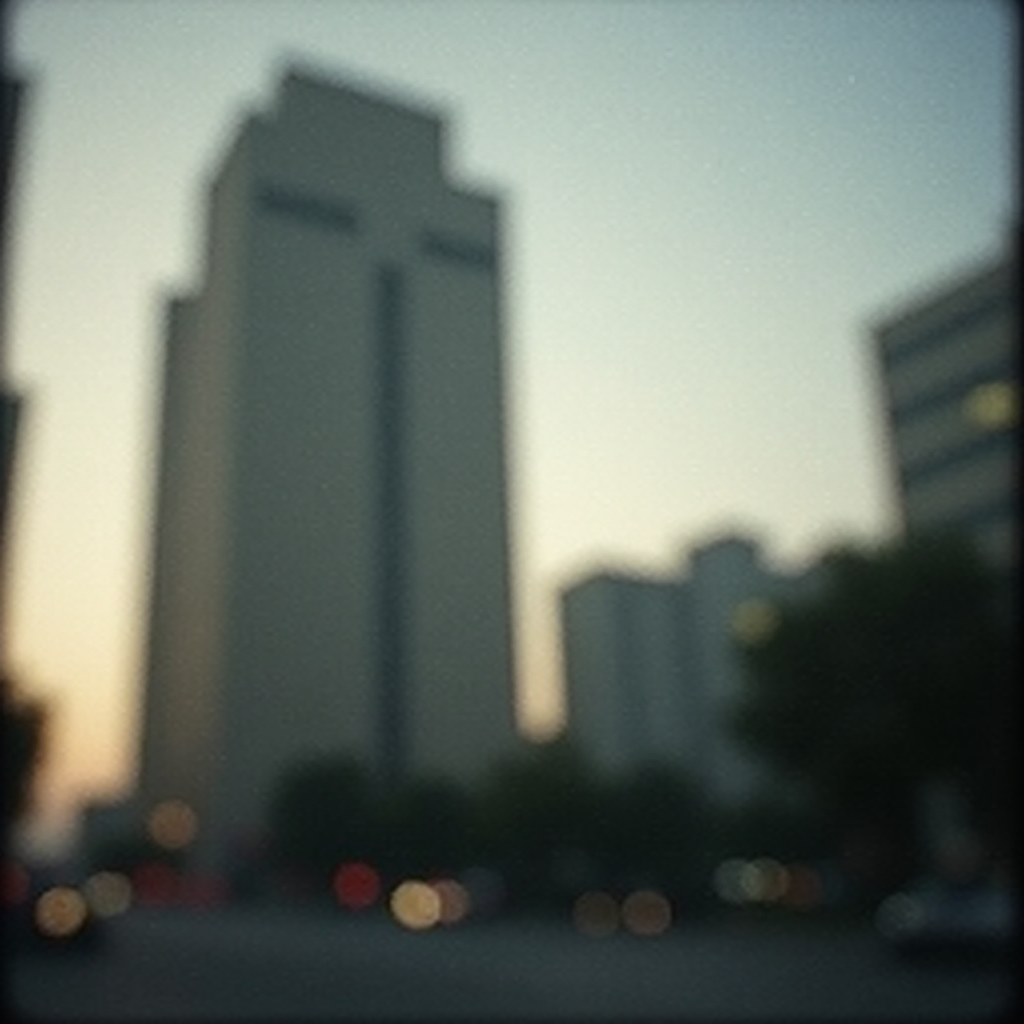

In [366]:
idx=success_index[877] 
print(dataset[idx]["hpsv3_reward"]["hpsv3_diop"][0], dataset[idx]["hpsv3_reward"]["hpsv3_didp"][0])
print(dataset[idx]["prompt_distorted"])
print(dataset[idx]["llm_judge"]["llm_distorted_special_effects"])
distorted_images[idx]

9.37739086151123 11.55752944946289
the building looms over the city and its windows are reflecting the sunlight


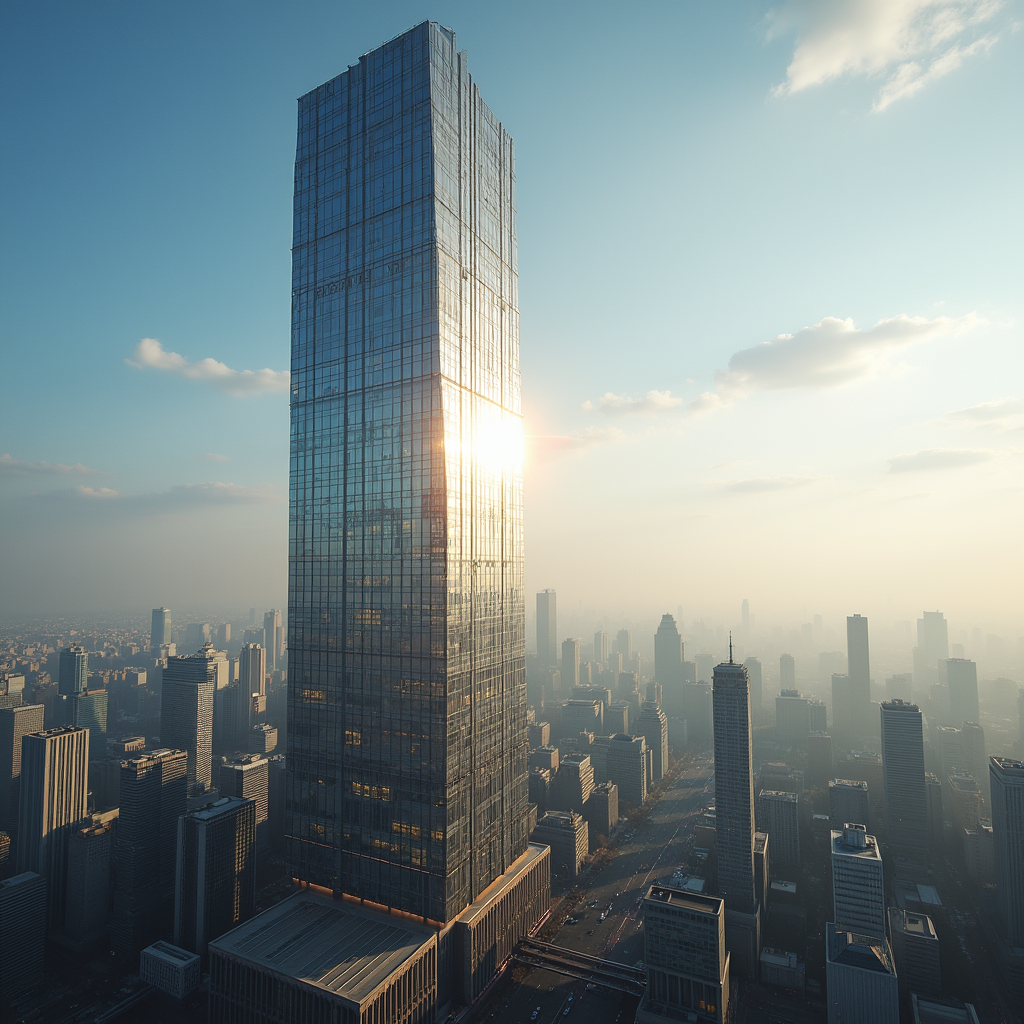

In [367]:
print(dataset[idx]["hpsv3_reward"]["hpsv3_oiop"][0], dataset[idx]["hpsv3_reward"]["hpsv3_oidp"][0])
print(dataset[idx]["prompt_original"])
original_images[idx]